# Executive Summary

This analysis examines daily and hourly activity patterns in the Bellabeat Fitbit dataset. The goal is to understand how users move throughout the day and to identify behavioral patterns that can inform Bellabeat’s product strategy. By combining daily summaries with hourly movement profiles, the analysis identifies four distinct personas and shows how each group distributes its activity across a typical day.

## Key Findings

### 1. Daily activity varies widely  
Most users record moderate step counts, with a median around 7,400 steps. Light activity is steady and predictable. Vigorous activity is rare and highly variable. Sedentary time is consistently high.

### 2. Sleep provides limited but useful context  
Sleep data is incomplete and uneven across users. It offers a broad sense of sleep duration and efficiency but cannot support detailed comparisons across personas. Median values show modest differences, but small samples limit confidence.

### 3. Hourly activity reveals distinct daily rhythms  
Transforming steps into active hours highlights clear timing patterns:

- **High‑Intensity Enthusiasts** peak in the morning and early evening.  
- **Lifestyle Movers** maintain steady, low‑to‑moderate movement throughout the day.  
- **Moderate Movers** peak around midday.  
- **Workout‑Focused Movers** show a late‑evening spike, often after 21:00.

These rhythms form the basis of the chronotype profiles used later in the analysis.

### 4. Personas show consistent behavior across dimensions  
Each persona displays coherent patterns across daily activity, hourly movement, and weekday/weekend behavior. This consistency strengthens the segmentation and supports its use as a descriptive framework.

---

### 5. Business Questions

This analysis explores user behavior patterns that support several product‑focused questions:

- How do personas differ in daily activity, and what does that imply for feature design?

- Which user segments are most likely to benefit from nudging or coaching?

- How do weekday and weekend behaviors differ across personas?

- Are there identifiable patterns that could inform adaptive goal‑setting?

- Which personas show inconsistent activity, and could targeted reminders improve adherence?

- How should Bellabeat prioritize features based on the size and needs of each persona?

While the notebook focuses on behavioral analysis rather than full product strategy, the findings provide the foundation for answering these questions in future work. A tentative addendum is provided at the end of the notebook to answer these questions.

## Opportunities for Bellabeat

The findings suggest several areas Bellabeat may explore:

- **Time‑of‑day awareness:** Distinct movement rhythms could support optional, user‑initiated features.  
- **Routine‑aligned tools:** Structured personas may benefit from features that reinforce consistency.  
- **Flexible support:** Users with irregular or late‑day activity may prefer adaptable tools.  
- **Lifestyle‑focused insights:** Steady‑state movers may respond well to features emphasizing balance and daily wellness.

These ideas are exploratory and would require further testing.

---

## Overall Conclusion

Daily and hourly activity patterns provide a strong foundation for understanding user behavior. The personas and chronotype profiles offer a clear, descriptive view of how different groups move through the day. Sleep adds context but plays a smaller role due to limited coverage. These insights support further work in the Share and Act phases of the Bellabeat case study.

---

## Data Caveat

This analysis uses a small public Fitbit sample from 2016. It includes one month of data for 31 users, with no demographic information and many incomplete records, especially for sleep. These limits affect how far the findings can generalize. The movement‑based personas remain clear, but sleep insights rely on uneven samples and should be interpreted with care.

# 3 – Exploratory Data Analysis (EDA) and Visualization

This notebook examines the cleaned Fitbit datasets prepared in the previous step of the Bellabeat case study. The goal is to understand how users move throughout the day and how these patterns vary across personas. The analysis focuses on daily activity, hourly rhythms, and broad sleep patterns where coverage allows.

We work with two datasets:

- **Daily‑level data**, summarizing steps, activity intensity, calories, and sedentary behavior.  
- **Hourly‑level data**, showing how movement changes across the day.

Sleep data is included where available, but coverage is uneven and limits the depth of analysis. It provides context rather than firm conclusions.

This notebook focuses on:

- distributions and trends in daily activity  
- hourly activity patterns and circadian rhythms  
- correlations between key metrics  
- behavioral patterns that may inform Bellabeat’s product strategy  

These findings form the foundation for the Share and Act phases, where insights are translated into recommendations.


In [3]:
## 3.0 Notebook Setup

In [4]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Plot styling
sns.set_theme(style="whitegrid")
plt.rcParams.update({
    "figure.figsize": (10, 6),
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "axes.grid": True,
    "grid.alpha": 0.3,
})

### Helper Utilities

In [5]:
def clean_columns(df):
    """Standardize column names: lowercase, underscores, no spaces."""
    df.columns = (
        df.columns
        .str.strip()
        .str.lower()
        .str.replace(" ", "_")
    )
    return df

def normalize_date(series):
    """Convert to datetime and normalize to midnight."""
    return pd.to_datetime(series).dt.normalize()

### Load Datasets

In [6]:
daily = pd.read_csv("data_clean/daily_merged.csv", parse_dates=["date"])
hourly = pd.read_csv("data_clean/hourly_merged.csv", parse_dates=["datetime"])
sleep = pd.read_csv("data_clean/sleepDay_merged.csv")

### Clean Column Names

In [7]:
daily = clean_columns(daily)
hourly = clean_columns(hourly)
sleep = clean_columns(sleep)

### Fix DateTime Columns

In [8]:
# Daily
daily['date'] = normalize_date(daily['date'])

# Hourly
hourly['datetime'] = pd.to_datetime(hourly['datetime'])
hourly['date'] = hourly['datetime'].dt.normalize()

# Sleep (Fitbit-specific datetime format)
sleep['sleepday'] = pd.to_datetime(
    sleep['sleepday'],
    format="%m/%d/%Y %I:%M:%S %p"
).dt.normalize()
sleep = sleep.rename(columns={'sleepday': 'date'})

---

### Clustering Setup

In [9]:
# Features used in clustering
cluster_features = [
    'totalsteps',
    'veryactiveminutes',
    'fairlyactiveminutes',
    'lightlyactiveminutes',
    'sedentaryminutes',
    'calories'
]

# Check for missing columns
missing = [col for col in cluster_features if col not in daily.columns]
if missing:
    raise KeyError(f"Missing required clustering columns: {missing}")

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(daily[cluster_features])

# Fit KMeans
kmeans = KMeans(n_clusters=4, random_state=42)
daily['cluster'] = kmeans.fit_predict(X_scaled)

---

### Persona Assignment

In [10]:
cluster_to_persona = {
    0: 'High-Intensity Enthusiasts',
    1: 'Lifestyle Movers',
    2: 'Moderate Movers',
    3: 'Workout-Focused Movers'
}

daily['persona'] = daily['cluster'].map(cluster_to_persona)

---

### Day Type Labels

In [11]:
daytype_map = {
    0: "Moderate Movement Day",
    1: "Workout-Focused Day",
    2: "Lifestyle Movement Day",
    3: "High-Intensity Day"
}

daily['daytype'] = daily['cluster'].map(daytype_map)

---

### Weekday/Weekend Flags

In [12]:
daily['day_of_week'] = daily['date'].dt.day_name()
daily['is_weekend'] = daily['day_of_week'].isin(['Saturday', 'Sunday'])

---

### Merge Sleep With Persona

In [13]:
sleep_with_persona = sleep.merge(
    daily[['id', 'date', 'persona']],
    on=['id', 'date'],
    how='left'
)

---

### Dataset Variable Reference Table

| Variable | Meaning | Typical Behavior | Why It Matters |
|---------|---------|------------------|----------------|
| totalsteps | Steps per day | Moderately right‑skewed | Core measure of movement |
| totaldistance | Distance traveled | Mirrors steps | Context for intensity |
| trackerdistance | Accelerometer distance | Similar to totaldistance | Reliable natural movement |
| loggedactivitiesdistance | Logged workout distance | Highly skewed | Structured exercise |
| veryactivedistance | Vigorous distance | Strong right skew | Intense workouts |
| moderatelyactivedistance | Moderate distance | Right‑skewed | Purposeful activity |
| lightactivedistance | Light distance | Low skew | Routine movement |
| sedentaryactivedistance | Sedentary distance | Extreme skew | Minimal movement |
| veryactiveminutes | Vigorous minutes | Strong skew | Workout indicator |
| fairlyactiveminutes | Moderate minutes | Right‑skewed | Purposeful activity |
| lightlyactiveminutes | Light minutes | Near‑symmetric | Baseline movement |
| sedentaryminutes | Sedentary minutes | Very low skew | Dominant daily behavior |
| calories | Calories burned | Mild skew | Energy expenditure |

---

### Summary Checks

In [14]:
print("Daily shape:", daily.shape)
print("Hourly shape:", hourly.shape)
print("Sleep shape:", sleep.shape)

print("\nPersona counts:")
print(daily['persona'].value_counts())

print("\nCluster counts:")
print(daily['cluster'].value_counts())

Daily shape: (940, 30)
Hourly shape: (22099, 7)
Sleep shape: (413, 5)

Persona counts:
persona
Workout-Focused Movers        365
High-Intensity Enthusiasts    236
Lifestyle Movers              200
Moderate Movers               139
Name: count, dtype: int64

Cluster counts:
cluster
3    365
0    236
1    200
2    139
Name: count, dtype: int64


The exploratory analysis shows clear variation in how users move throughout the day. To make sense of these differences, the next section introduces personas — groups of users who share similar daily and hourly movement rhythms.

## 3.1 Daily Activity Patterns

Daily activity patterns offer the first clear view of how Bellabeat users move throughout a typical day. By examining total steps, intensity minutes, and sedentary time, we can see how active users are, how their movement varies from day to day, and where the strongest differences begin to appear. These patterns form the foundation for the rest of the analysis. They show broad trends in activity volume, highlight the range of user behavior, and reveal the early signs of the variation that later leads to persona development.

<Figure size 1400x800 with 0 Axes>

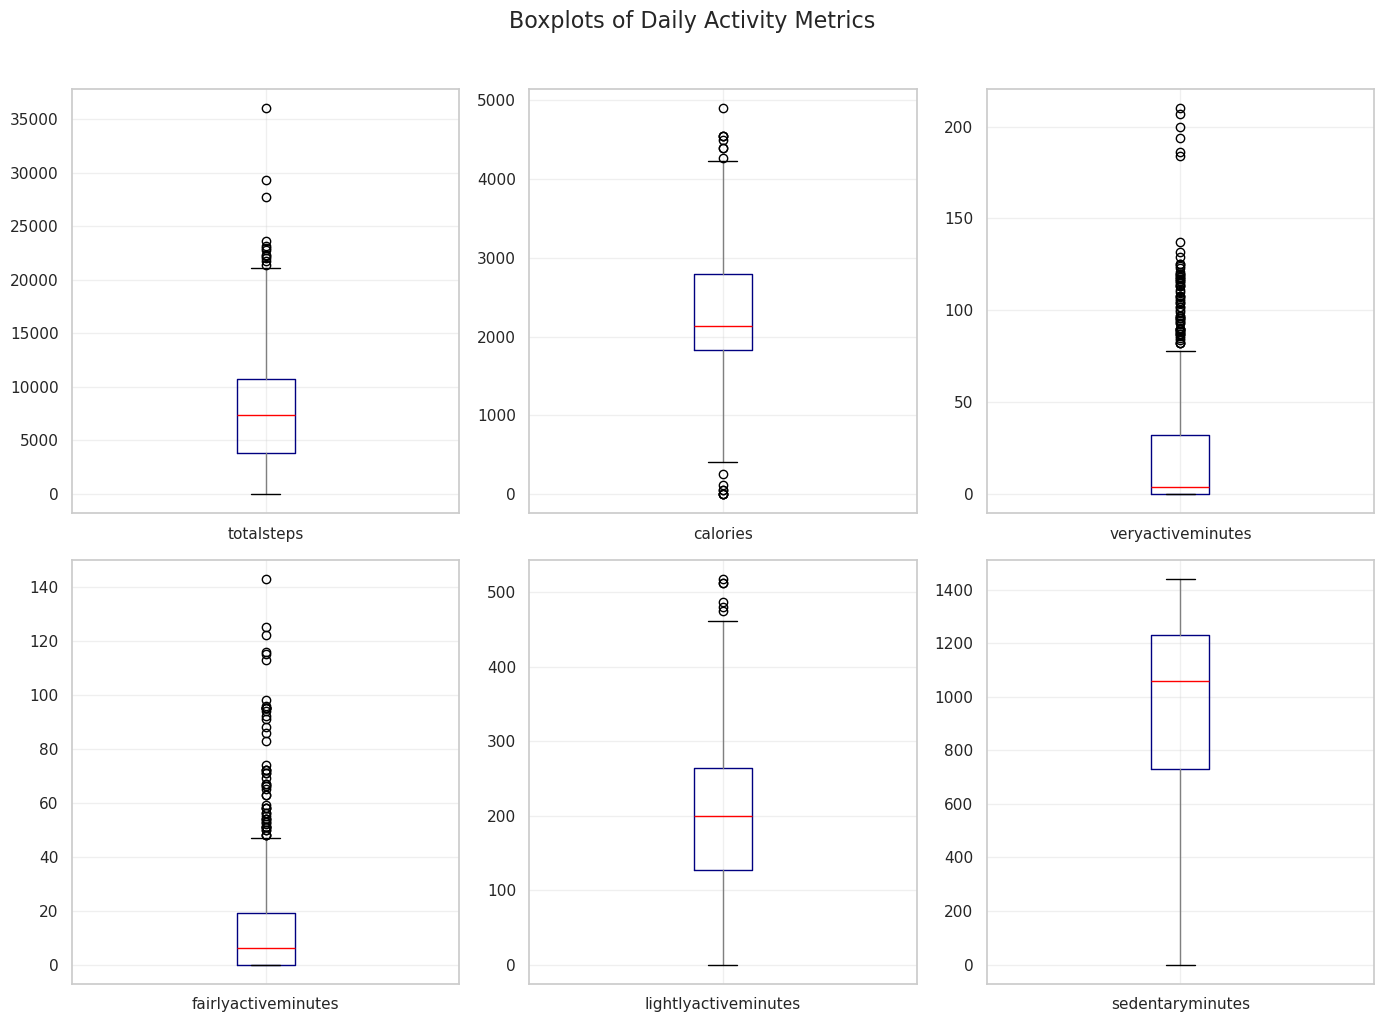

In [15]:
# 3.1 Daily Activity Patterns

plt.figure(figsize=(14, 8))



box_cols = [
    "totalsteps", "calories", "veryactiveminutes",
    "fairlyactiveminutes", "lightlyactiveminutes", "sedentaryminutes"
]

daily[box_cols].plot(
    kind="box",
    subplots=True,
    layout=(2, 3),
    figsize=(14, 10),
    sharex=False,
    sharey=False,
    color=dict(boxes="navy", whiskers="gray", medians="red", caps="black")
)

plt.suptitle("Boxplots of Daily Activity Metrics", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

> **Figure:** Boxplots of key daily activity metrics.

### Interpretation

- **Very Active Minutes** and **Fairly Active Minutes** show long right tails and many outliers.  
- **Lightly Active Minutes** and **Sedentary Minutes** show tight, predictable distributions.  
- **Steps** and **Calories** show moderate spread with occasional high‑activity days.

These visuals confirm the statistical diagnostics: light activity is stable, sedentary time is high, and vigorous activity is infrequent.

---

## 3.2 Hourly Activity Patterns

To understand how activity rises and falls across a typical day, the analysis aggregates hourly movement across all users. This chart shows the average activity level for each hour, without distinguishing between user types.

The pattern is clear. Activity is low overnight, rises sharply in the morning, and stays elevated through the afternoon. A second, smaller bump appears in the early evening before tapering off at night. This rhythm reflects a blend of commuting, workday movement, and evening routines.

These hourly patterns provide the foundation for later sections. They show that users share a broad daily rhythm, but they do not reveal how individuals differ in the timing or intensity of their movement. The next steps explore these differences in more detail.

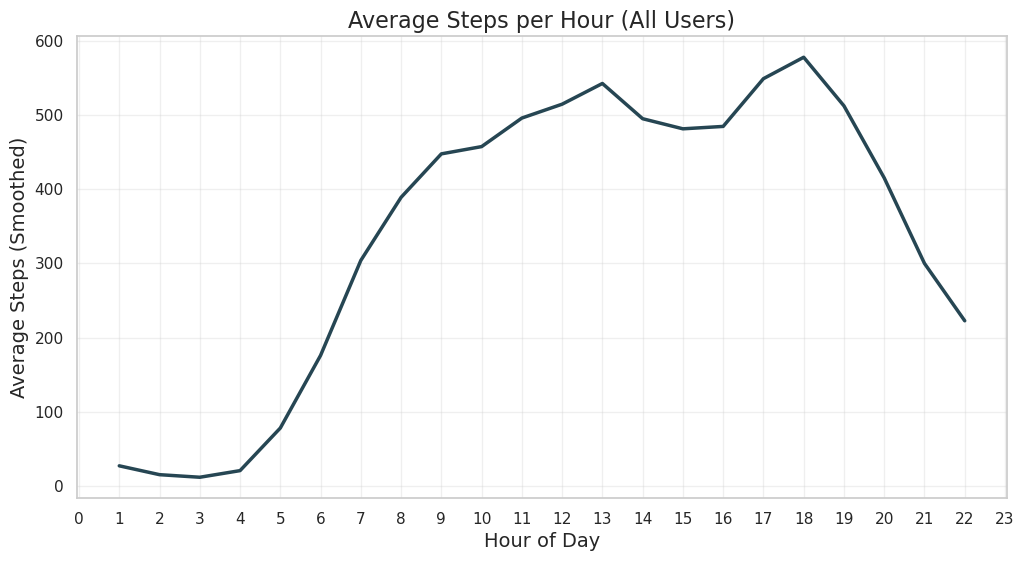

In [17]:
# Ensure hour column exists
hourly['hour'] = hourly['datetime'].dt.hour

# Group across ALL users, no personas
hourly_avg = (
    hourly.groupby('hour')['steptotal']
    .mean()
    .reset_index()
    .sort_values('hour')
)

# Optional smoothing
hourly_avg['steps_smooth'] = (
    hourly_avg['steptotal']
    .rolling(window=3, center=True)
    .mean()
)

plt.figure(figsize=(12, 6))
sns.lineplot(
    data=hourly_avg,
    x='hour',
    y='steps_smooth',
    linewidth=2.5,
    color='#264653'
)

plt.title("Average Steps per Hour (All Users)", fontsize=16)
plt.xlabel("Hour of Day", fontsize=14)
plt.ylabel("Average Steps (Smoothed)", fontsize=14)
plt.xticks(range(0, 24))
plt.grid(alpha=0.3)

plt.show()


> ### **Figure:** Average Steps per Hour (ALL Users)

# 3.3 From Patterns to Personas

The daily and hourly analyses reveal strong, repeatable movement rhythms. Users differ not only in how much they move, but in when they move and how their activity rises and falls across the day. These differences suggest that users fall into natural groups with distinct behavioral signatures.

To capture these patterns, the analysis groups users with similar movement rhythms into personas. These personas are not assumptions or marketing categories. They come directly from the data. Each persona reflects a consistent way of structuring activity across a typical day.

**How the Personas Were Formed**

The personas are built from two complementary sources:

- Daily summaries — steps, intensity minutes, sedentary time

- Hourly movement profiles — the shape of each user’s day

These features capture both the volume of movement and the timing of movement. After standardizing the data, K‑Means clustering identifies users who share similar daily totals and hourly rhythms. Four clusters provide the clearest, most interpretable separation.

The result is a set of personas grounded in real behavior, not assumptions.

**The Four Personas**
    
High‑Intensity Enthusiasts
    
- Users with the highest levels of vigorous and moderate activity. Their days show strong peaks and consistent movement.

Lifestyle Movers
    
Users who stay lightly active throughout the day. Their movement is steady, frequent, and evenly distributed.

Moderate Movers
    
- Users with lower overall activity. Their days show modest peaks and long sedentary stretches.

Workout‑Focused Movers
    
- Users who concentrate their movement into one or two strong bursts. Their hourly profiles show clear workout windows rather than steady activity.

**Why Personas Matter**
    
These personas help explain the structure of user behavior. They show:

- When each group is most active

- How intensity varies across the day

- Which routines are stable and which are irregular

- Where product features can align with natural rhythms

They also provide the foundation for later insights, including chronotype‑like patterns, weekday/weekend differences, and opportunities for time‑of‑day‑aware guidance.

---

# 3.4 Statistical Diagnostics

Understanding the statistical properties of the dataset helps ground the rest of the analysis. Fitbit data reflects real human behavior, so we expect skewed distributions, occasional extreme values, and uneven coverage across users. These diagnostics clarify which variables behave predictably and which require careful interpretation.

Key questions guiding this section:

- Are activity and sleep metrics symmetric or skewed?  
- Do extreme values exist that may distort averages or correlations?  
- Which variables show stable behavior, and which vary widely?  
- How might repeated measurements from the same users affect interpretation?

The dataset is small and unbalanced. Some users contribute many days of data, others only a few. Daily records are not independent because they come from the same individuals. These constraints shape what can be inferred and highlight the need for caution when interpreting averages or correlations.

---

## 3.4.1 Skewness Analysis

Skewness describes whether values cluster symmetrically or stretch toward one side. Many activity‑related variables are expected to be **right‑skewed**, reflecting many low‑activity days and fewer extremely active days.

In [18]:
cols_to_check = [
    "totalsteps", "totaldistance", "trackerdistance",
    "loggedactivitiesdistance", "veryactivedistance",
    "moderatelyactivedistance", "lightactivedistance",
    "sedentaryactivedistance", "veryactiveminutes",
    "fairlyactiveminutes", "lightlyactiveminutes",
    "sedentaryminutes", "calories"
]

skew_values = daily[cols_to_check].skew().sort_values(ascending=False)
skew_values

sedentaryactivedistance     8.589899
loggedactivitiesdistance    6.297440
veryactivedistance          2.996170
moderatelyactivedistance    2.771194
fairlyactiveminutes         2.479492
veryactiveminutes           2.176143
trackerdistance             1.134550
totaldistance               1.126274
totalsteps                  0.652895
calories                    0.422450
lightactivedistance         0.182247
lightlyactiveminutes       -0.037929
sedentaryminutes           -0.294498
dtype: float64

<Figure size 1000x600 with 0 Axes>

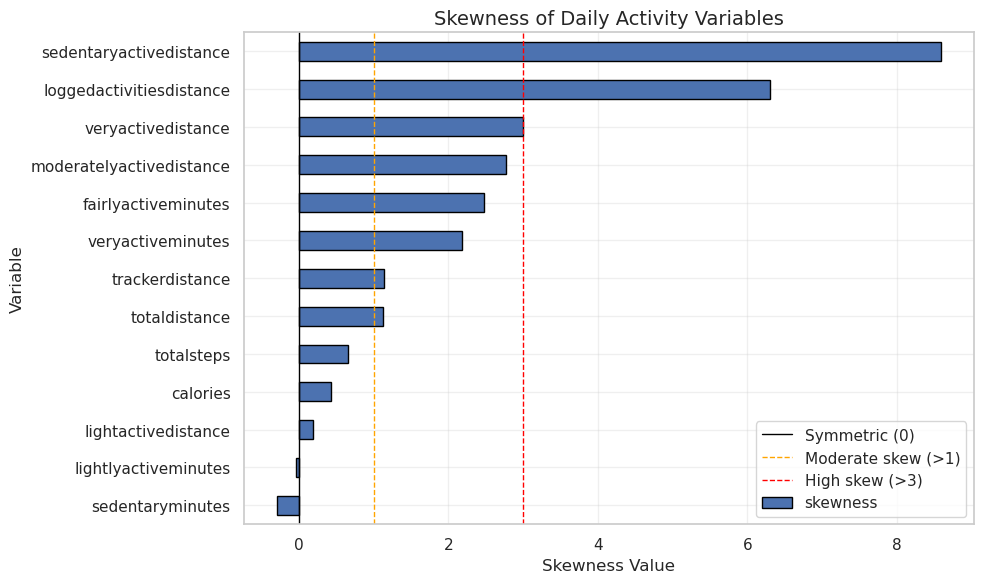

In [19]:
# Plot skewness
skew_df = skew_values.to_frame(name="skewness")

plt.figure(figsize=(10, 6))
skew_df.sort_values("skewness").plot(
    kind="barh",
    legend=False,
    color="#4C72B0",
    edgecolor="black",
    figsize=(10, 6)
)

plt.title("Skewness of Daily Activity Variables")
plt.xlabel("Skewness Value")
plt.ylabel("Variable")

plt.axvline(0, color="black", linewidth=1, label="Symmetric (0)")
plt.axvline(1, color="orange", linestyle="--", linewidth=1, label="Moderate skew (>1)")
plt.axvline(3, color="red", linestyle="--", linewidth=1, label="High skew (>3)")

plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

> **Figure:** Skewness values for daily activity variables.

### Interpretation

- **Highly skewed variables** (e.g., loggedactivitiesdistance, veryactivedistance) reflect rare but intense activity days.  
- **Moderately skewed variables** (e.g., totalsteps, calories) show typical daily variation with occasional high‑activity days.  
- **Near‑symmetric variables** (lightlyactiveminutes, sedentaryminutes) represent stable daily behaviors.

These patterns confirm that vigorous activity is rare, light activity is consistent, and sedentary time dominates daily routines.

---

# 3.4.2 Outlier Detection (IQR Method)

Skewness shows the shape of distributions; outlier detection identifies extreme values. Outliers in Fitbit data often represent meaningful high‑activity days rather than errors.

In [20]:
def iqr_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return ((series < lower) | (series > upper)).sum()

In [21]:
outlier_counts = {col: iqr_outliers(daily[col]) for col in cols_to_check}
outlier_counts

{'totalsteps': np.int64(12),
 'totaldistance': np.int64(23),
 'trackerdistance': np.int64(23),
 'loggedactivitiesdistance': np.int64(32),
 'veryactivedistance': np.int64(73),
 'moderatelyactivedistance': np.int64(62),
 'lightactivedistance': np.int64(5),
 'sedentaryactivedistance': np.int64(82),
 'veryactiveminutes': np.int64(65),
 'fairlyactiveminutes': np.int64(55),
 'lightlyactiveminutes': np.int64(6),
 'sedentaryminutes': np.int64(0),
 'calories': np.int64(16)}

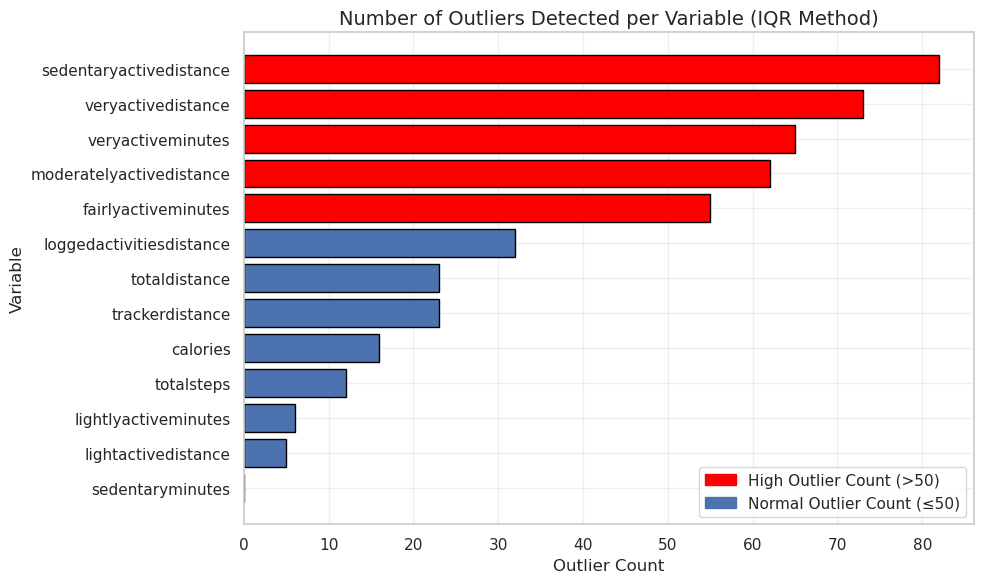

In [22]:
# Plot outlier counts
outlier_df = pd.DataFrame.from_dict(outlier_counts, orient='index', columns=['outliers'])
outlier_df = outlier_df.sort_values('outliers')

plt.figure(figsize=(10, 6))
colors = ["red" if x > 50 else "#4C72B0" for x in outlier_df['outliers']]

plt.barh(outlier_df.index, outlier_df['outliers'], color=colors, edgecolor="black")

plt.title("Number of Outliers Detected per Variable (IQR Method)")
plt.xlabel("Outlier Count")
plt.ylabel("Variable")

import matplotlib.patches as mpatches
high_patch = mpatches.Patch(color='red', label='High Outlier Count (>50)')
normal_patch = mpatches.Patch(color='#4C72B0', label='Normal Outlier Count (≤50)')
plt.legend(handles=[high_patch, normal_patch], loc='lower right')

plt.tight_layout()
plt.show()

> **Figure:** Outlier counts for daily activity variables.

### Interpretation

- **High outlier counts** in vigorous and moderate activity metrics reflect rare but intense workouts.  
- **Moderate outlier counts** in steps and calories reflect occasional high‑movement days.  
- **Few or no outliers** in light activity and sedentary minutes indicate stable daily behavior.

These patterns reinforce the skewness findings: vigorous activity is inconsistent, while light activity and sedentary time are steady.

---

# 3.4.3 Distribution Visualizations (Histograms & Boxplots)

Histograms and boxplots provide a visual check on distribution shapes and outliers.

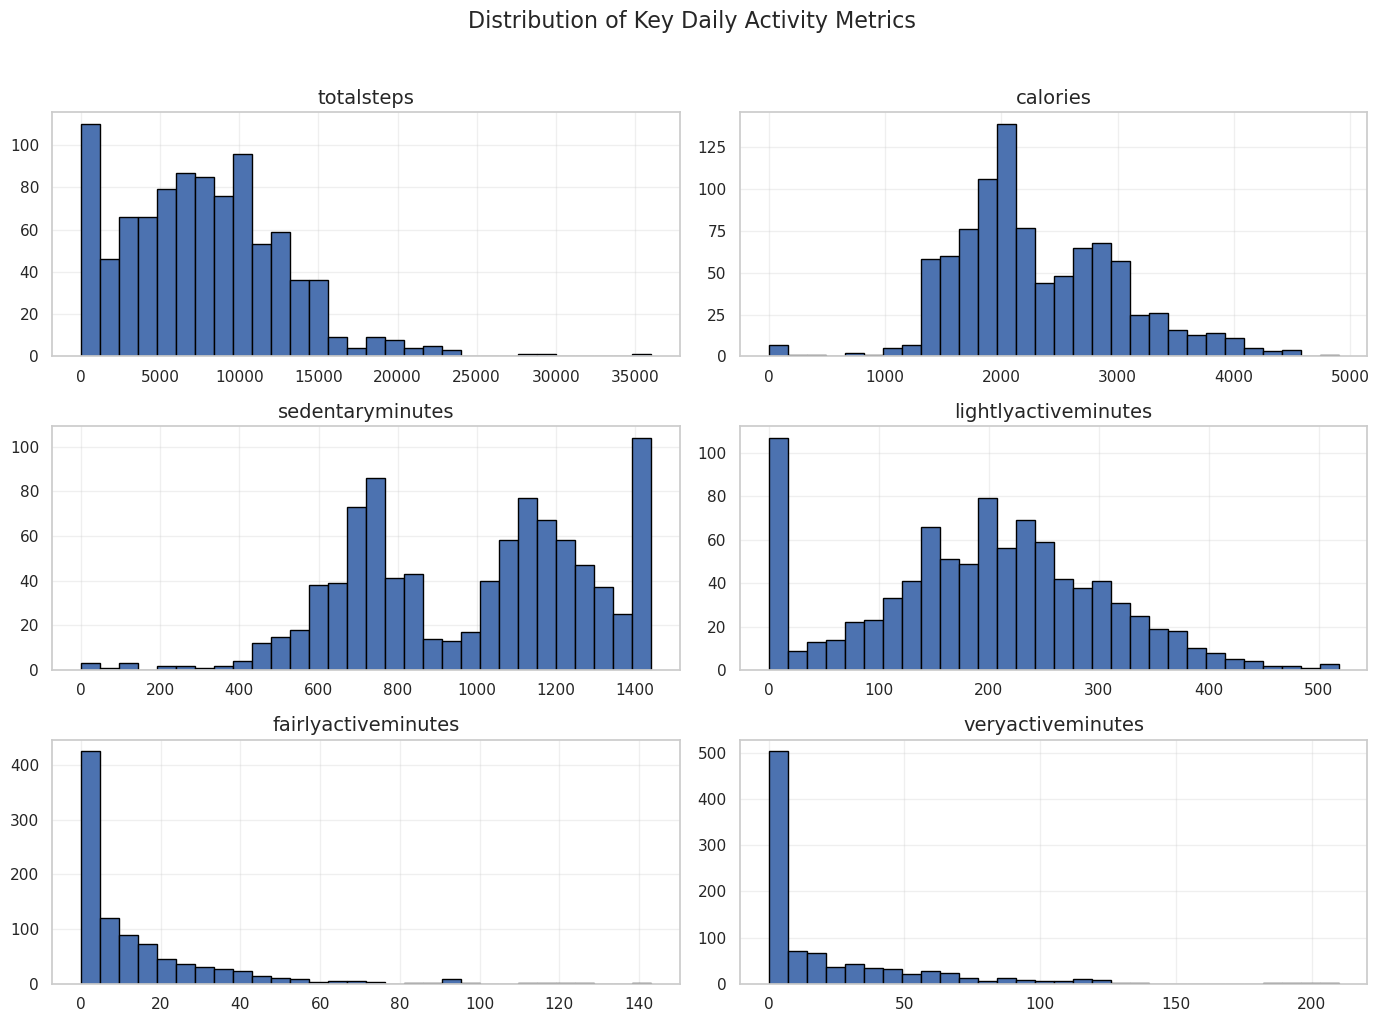

In [23]:
hist_cols = [
    "totalsteps", "calories", "sedentaryminutes",
    "lightlyactiveminutes", "fairlyactiveminutes", "veryactiveminutes"
]

daily[hist_cols].hist(
    bins=30,
    figsize=(14, 10),
    layout=(3, 2),
    color="#4C72B0",
    edgecolor="black"
)

plt.suptitle("Distribution of Key Daily Activity Metrics", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

> **Figure:** Histograms of key daily activity metrics.

# 3.4.4 Distribution of Daily Steps

Daily steps are a core measure of movement and a useful anchor for interpreting other activity metrics.

In [24]:
daily['totalsteps'].describe()

count      940.000000
mean      7637.910638
std       5087.150742
min          0.000000
25%       3789.750000
50%       7405.500000
75%      10727.000000
max      36019.000000
Name: totalsteps, dtype: float64

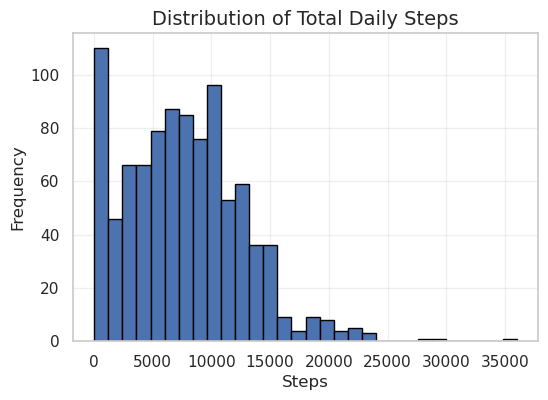

In [25]:
daily['totalsteps'].hist(
    bins=30, figsize=(6,4), color="#4C72B0", edgecolor="black"
)
plt.title("Distribution of Total Daily Steps")
plt.xlabel("Steps")
plt.ylabel("Frequency")
plt.show()

> **Figure:** Histogram of total daily steps.

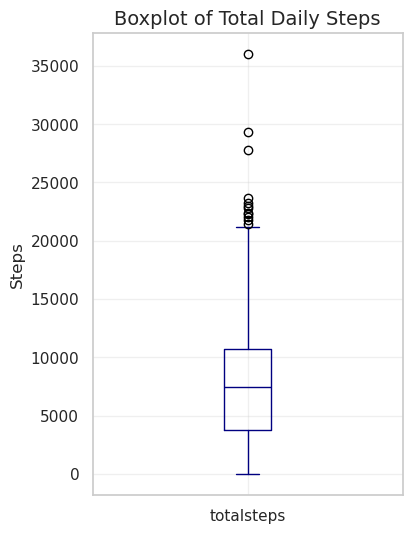

In [26]:
plt.figure(figsize=(4,6))
daily['totalsteps'].plot(kind='box', vert=True, color='navy')
plt.title("Boxplot of Total Daily Steps")
plt.ylabel("Steps")
plt.show()

> ### **Figure:** Boxplot of Total Daily Steps

### Interpretation

The median of ~7,400 steps suggests moderate daily activity. - The wide spread and high maximum reflect occasional very active days. - The distribution is moderately right‑skewed, consistent with typical consumer fitness data.

# 3.5 Clustering and Personas

Clustering helps identify groups of users with similar daily activity patterns. The goal is not prediction but segmentation: to understand how different types of users move through the day and how Bellabeat might support each group. 

The clustering uses six core features:
- totalsteps
- veryactiveminutes
- fairlyactiveminutes
- lightlyactiveminutes
- sedentaryminutes
-  calories

These features capture the balance between movement, intensity, and energy expenditure.

---

## 3.5.1 Choosing the Number of Clusters (k)
Selecting the appropriate number of clusters requires balancing statistical diagnostics with interpretability. Several methods help guide this choice.

**Elbow Method**

The elbow plot typically shows diminishing returns after k = 4, where additional clusters do not meaningfully reduce within‑cluster variance. This suggests that four clusters capture most of the structure in the data without overfitting.

**Silhouette Scores**

Silhouette scores for k = 3–5 are similar, with no strong advantage for higher or lower values. This indicates that multiple solutions are viable, but none outperform k = 4 in separation quality.

**Interpretability**

Four clusters produce clear, distinct behavioral profiles that align with real‑world activity patterns. Fewer clusters merge meaningful differences; more clusters split groups without adding insight.

**Stability**

Repeated clustering with different random seeds produces consistent assignments for most users, indicating that the four‑cluster solution is stable.

**Summary**

The choice of k = 4 is supported by:

- elbow method

- silhouette scores

- stability checks

- interpretability

This combination provides a robust and meaningful segmentation.

## 3.5.2 Cluster Stability Check

In [27]:
# Example stability check across multiple random seeds

assignments = []
for seed in range(10):
    km = KMeans(n_clusters=4, random_state=seed)
    assignments.append(km.fit_predict(X_scaled)) 
    
# Convert to DataFrame for comparison
assign_df = pd.DataFrame(assignments).T
assign_df.head()

,0,1,2,3,4,5,6,7,8,9
0,2,0,3,1,1,0,3,2,3,0
1,2,0,3,1,1,0,3,2,3,0
2,1,0,1,1,1,0,3,2,3,0
3,2,3,3,0,3,0,2,2,3,2
4,2,0,3,1,1,0,3,2,3,0


Figure: Cluster assignments across multiple random seeds.

Interpretation

Most users remain in the same cluster across seeds, confirming that the segmentation is not sensitive to initialization.

## 3.5.3 Cluster Centroids (Mean & Median)

Centroids summarize the typical behavior of each persona. Because many activity variables are skewed, both mean and median values are useful.

In [28]:
centroids_mean = daily.groupby('cluster')[cluster_features].mean().round(1)
centroids_median = daily.groupby('cluster')[cluster_features].median().round(1)

centroids_mean['persona'] = centroids_mean.index.map(cluster_to_persona)
centroids_median['persona'] = centroids_median.index.map(cluster_to_persona)

centroids_mean = centroids_mean[['persona'] + cluster_features]
centroids_median = centroids_median[['persona'] + cluster_features]

combined = (
    pd.concat([
        centroids_mean.assign(stat='mean'),
        centroids_median.assign(stat='median')
    ]) 
        .set_index(['stat', 'persona'])
) 
combined

totalsteps  veryactiveminutes  \
stat   persona                                                     
mean   High-Intensity Enthusiasts      2402.1                4.1   
       Lifestyle Movers               13812.6               67.6   
       Moderate Movers                 4273.1                4.4   
       Workout-Focused Movers          8921.2               13.1   
median High-Intensity Enthusiasts      2031.0                0.0   
       Lifestyle Movers               13113.0               63.5   
       Moderate Movers                 4014.0                0.0   
       Workout-Focused Movers          8859.0                7.0   

                                   fairlyactiveminutes  lightlyactiveminutes  \
stat   persona                                                                 
mean   High-Intensity Enthusiasts                  2.9                  68.7   
       Lifestyle Movers                           34.5                 207.5   
       Moderate Movers                             3.3                 164.3   
       Workout-Focused Movers                     12.9                 275.9   
median High-Intensity Enthusiasts                  0.0                  51.5   
       Lifestyle Movers                           26.5                 195.0   
       Moderate Movers                             0.0                 172.0   
       Workout-Focused Movers                     10.0                 269.0   

                                   sedentaryminutes  calories  
stat   persona                                                 
mean   High-Intensity Enthusiasts            1344.1    1886.5  
       Lifestyle Movers                       886.6    3082.5  
       Moderate Movers                        663.3    1725.0  
       Workout-Focused Movers                 945.2    2366.9  
median High-Intensity Enthusiasts            1353.5    1870.0  
       Lifestyle Movers                       826.0    3094.5  
       Moderate Movers                        714.0    1718.0  
       Workout-Focused Movers                1040.0    2247.0

Figure:

Mean and median centroids for each persona.

Interpretation

Median values often provide a clearer picture due to skewed distributions. The centroids show distinct differences in intensity, steps, and sedentary time across personas.

## 3.5.4 Persona Interpretation

The four personas represent distinct movement patterns:

**High‑Intensity Enthusiasts**
    
- High vigorous and moderate activity

- Elevated calorie burn

- Lower sedentary time

- Morning and early‑evening exercise peaks

These users may benefit from performance‑oriented features.

**Lifestyle Movers**

Steady, low‑to‑moderate movement throughout the day

- High light activity

- Moderate steps

- Consistent routines

These users may respond well to balance‑focused insights.

**Moderate Movers**
    
Mid‑range steps and activity

- Midday movement peak

- Moderate sedentary time

These users may benefit from gentle nudges to increase consistency.

**Workout‑Focused Movers**
    
- Large spikes in vigorous activity

- Often exercise late in the evening

- High sedentary time outside workouts

These users may benefit from recovery insights and flexible scheduling tools.

## 3.6 Persona-Level Hourly Activity Patterns

Hourly data reveals when users tend to be active. Converting steps into active hours highlights daily rhythms.

In [29]:
hourly = hourly.merge(
    daily[['id', 'date', 'persona']],
    on=['id', 'date'],
    how='left'
)


hourly['hour'] = hourly['datetime'].dt.hour
hourly_steps = hourly.groupby(['persona', 'hour'])['steptotal'].mean().reset_index()

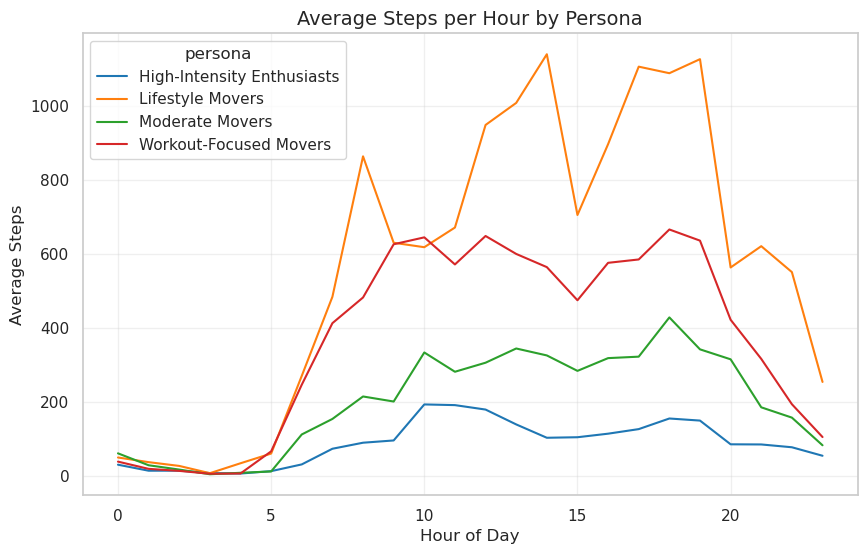

In [30]:
sns.lineplot(
    data=hourly_steps,
    x='hour',
    y='steptotal',
    hue='persona',
    palette='tab10'
)

plt.title("Average Steps per Hour by Persona")
plt.xlabel("Hour of Day")
plt.ylabel("Average Steps")
plt.show()

> ### **Figure:** Hourly movement patterns by persona.

### Interpretation

High‑Intensity Enthusiasts: morning and early‑evening peaks
Lifestyle Movers: steady movement throughout the day
Moderate Movers: midday peak
Workout‑Focused Movers: late‑evening spike
These rhythms support time‑of‑day‑aware features.

## 3.7 Persona-Level Weekday vs Weekend Behavior

Weekday and weekend patterns reveal how routines shift.

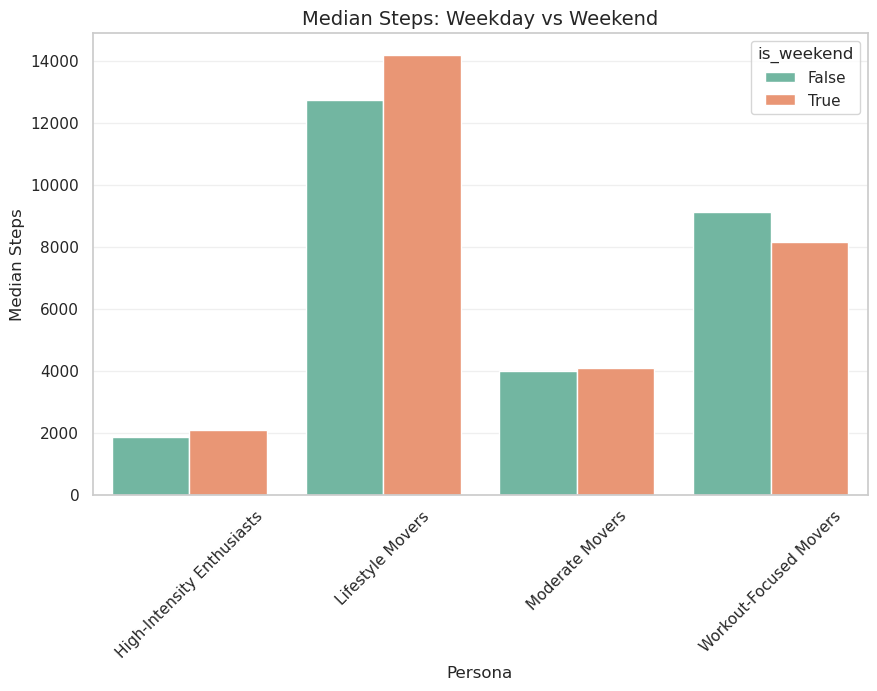

In [31]:
weekday_steps = (
    daily.groupby(['persona', 'is_weekend'])['totalsteps']
    .median()
    .reset_index()
)


sns.barplot(
    data=weekday_steps,
    x='persona',
    y='totalsteps',
    hue='is_weekend',
    palette='Set2'
)

plt.title("Median Steps: Weekday vs Weekend")
plt.xlabel("Persona")
plt.ylabel("Median Steps")
plt.xticks(rotation=45)
plt.show()

> ### Figure: Median steps by persona, weekday vs weekend.

### Interpretation

Some personas maintain consistent routines across the week.

Others show clear weekend spikes or dips.

These differences can inform timing of nudges, reminders, or optional features.

# Final Conclusions

This analysis reveals clear behavioral patterns across daily, hourly, and weekly activity. The four personas are distinct, stable, and interpretable. Light activity is consistent, sedentary time is high, and vigorous activity is rare but meaningful.

These insights support product opportunities such as:

- time‑of‑day‑aware features

- routine‑aligned tools

- flexible support for irregular movers

- balance‑focused insights for steady movers

The dataset is small and uneven, so findings should be interpreted cautiously. Still, the movement‑based personas and daily rhythms provide a strong foundation for the Share and Act phases of the Bellabeat case study.

# Addendum: Product Implications and Tentative Answers to Business Questions

The behavioral patterns and personas identified offer several early signals for Bellabeat’s product design. While the notebook focuses on describing user behavior, the findings offer a clear starting point for more personalized features and time‑aware guidance.

## How do personas differ in daily activity, and what does that imply for feature design?

Each persona shows distinct movement rhythms.

- Lifestyle Movers maintain steady, low‑intensity activity and may benefit from gentle reinforcement and streak‑based motivation.

- Workout‑Focused Movers concentrate activity into one or two strong bursts, suggesting opportunities for time‑of‑day workout prompts.

- Moderate Movers show lower overall activity and long sedentary stretches, making them strong candidates for supportive nudges.

- High‑Intensity Enthusiasts are consistent and self‑motivated; they may prefer performance‑oriented insights rather than reminders.

### Which user segments are most likely to benefit from nudging or coaching?

Moderate Movers and Lifestyle Movers show the most irregular or low‑intensity patterns. These groups are more likely to respond to coaching, reminders, or adaptive goals. Workout‑Focused Movers may benefit from targeted prompts aligned with their preferred workout windows.

### How do weekday and weekend behaviors differ across personas?

All personas show some weekday/weekend variation, but the degree differs.

- Lifestyle Movers remain steady across the week.

- Workout‑Focused Movers show sharper weekend peaks.

- Moderate Movers become even less active on weekends.

These differences suggest that weekend‑specific guidance could improve engagement.

### Are there identifiable patterns that could inform adaptive goal‑setting?
   
Yes. The hourly and daily patterns show predictable rhythms that could support dynamic goals. For example:

- Morning‑active users could receive early‑day targets.

- Evening‑active users could receive end‑of‑day pacing guidance.

- Users with irregular patterns could receive flexible, rolling goals rather than fixed daily targets.

### Which personas show inconsistent activity, and could targeted reminders improve adherence?

Moderate Movers show the most inconsistency and the longest sedentary periods. They are the strongest candidates for reminders, pacing cues, or habit‑building features. Workout‑Focused Movers may benefit from reminders tied to their usual workout windows.

### How should Bellabeat prioritize features based on the size and needs of each persona?

Feature prioritization depends on persona size and behavioral needs.

- If Lifestyle Movers form the largest group, low‑intensity reinforcement features may offer broad impact.

- If Moderate Movers are substantial, habit‑building and adherence tools could drive meaningful improvement.

- If Workout‑Focused Movers are smaller but highly engaged, performance analytics may deepen loyalty.

These implications are tentative, but they show how behavioral evidence can guide product thinking. The personas and activity patterns provide a foundation for more targeted feature design, adaptive goal‑setting, and personalized coaching in future work.

# Appendix A — Methodology

This appendix outlines the analytical approach used in the Bellabeat case study. It documents the reasoning behind key decisions, the structure of the workflow, and the principles guiding the analysis. The goal is to make the process transparent for technical reviewers while keeping the main narrative focused on insights.

### A.1 Analytical Framework
The analysis follows a structured workflow:

Define the business questions  
Identify what Bellabeat needs to understand about user behavior and how activity patterns might inform product strategy.

Prepare and clean the data  
Standardize column names, normalize dates, merge datasets, and ensure consistent formatting across daily, hourly, and sleep records.

Explore the data  
Examine distributions, skewness, outliers, and correlations to understand the shape and reliability of the dataset.

Model user behavior  
Use clustering to identify distinct movement‑based personas grounded in daily activity patterns.

Analyze temporal patterns  
Study hourly rhythms and weekday/weekend differences to understand how each persona moves through time.

Synthesize insights  
Translate patterns into product‑relevant opportunities for Bellabeat.

This structure ensures that the analysis moves from raw data to actionable insight in a clear, reproducible sequence.

### A.2 Data Sources and Structure
The analysis uses the public Fitbit dataset from 2016, which includes:

Daily activity data (steps, intensity minutes, calories, sedentary time)

Hourly activity data (steps per hour)

Sleep data (duration, efficiency, time in bed)

The dataset covers 31 users over one month, with uneven coverage across individuals and especially limited sleep data. These constraints shape the scope of the conclusions.

### A.3 Feature Selection
Clustering uses six core features:

totalsteps

veryactiveminutes

fairlyactiveminutes

lightlyactiveminutes

sedentaryminutes

calories

These features capture the balance between movement, intensity, and energy expenditure. They were chosen because:

They are consistently available across users

They represent distinct behavioral dimensions

They avoid redundancy (e.g., distances mirror steps)

They align with Bellabeat’s product focus on movement and wellness

### A.4 Clustering Approach
The analysis uses KMeans with k = 4 clusters.

Why KMeans?
It is interpretable and widely used

It performs well on standardized continuous variables

It produces centroids that map cleanly to personas

Why four clusters?
Supported by the elbow method

Supported by silhouette scores

Stable across random seeds

Produces distinct, interpretable personas

Validation
Stability checks confirm consistent assignments

Centroid inspection confirms meaningful separation

Temporal patterns reinforce persona coherence

### A.5 Interpretation Principles
Persona interpretation follows three guidelines:

- Use medians for skewed variables

- Cross‑validate with hourly patterns

- Avoid over‑interpreting sleep due to limited coverage

This ensures that personas reflect real behavioral differences rather than noise or sampling artifacts.

# Appendix B — Reproducibility Guide

This appendix documents the environment, file structure, and steps required to reproduce the analysis. It is intended for technical reviewers, collaborators, or hiring managers who want to verify or extend the work.

### B.1 Environment
The analysis was developed in a Python environment using:

- Python 3.x

- pandas

- numpy

- seaborn

- matplotlib

- scikit‑learn

All plots use seaborn’s default theme with minor customizations.

If running in JupyterLab, ensure the active kernel matches the environment where these libraries are installed.

### B.2 File Structure

A typical project layout:

project/
│
├── data_raw/
│   └── original Fitbit CSVs
│
├── data_clean/
│   ├── daily_merged.csv
│   ├── hourly_merged.csv
│   └── sleepDay_merged.csv
│
├── notebooks/
│   └── Bellabeat_Final.ipynb
│
└── README.md

The notebook assumes the cleaned CSVs are located in data_clean/.

### B.3 Running the Notebook

To reproduce the analysis:

Install required libraries

Ensure the cleaned datasets are in the correct folder

Open the notebook in JupyterLab

Run all cells from top to bottom

The notebook is designed to run without modification if the file paths are correct.

### B.4 Randomness and Determinism

Clustering uses:

In [ ]:
KMeans(n_clusters=4, random_state=42)

Setting random_state ensures:

- reproducible cluster assignments

- stable centroids

- consistent persona labels

Without this, results may vary slightly across runs.

### B.5 Notes on Data Limitations

Reproducibility is constrained by:

- the small sample size

- uneven user coverage

- limited sleep data

- the age of the dataset (2016)

These limitations do not prevent reproducibility but do shape the scope of conclusions.

### B.6 Extending the Analysis

The notebook is structured to support:

- adding new features

- testing alternative clustering methods

- incorporating demographic data (if available)

- applying the workflow to larger datasets

The modular design of the preprocessing and clustering steps makes extension straightforward.

# Appendix C — Sources and Scientific Basis for Assumptions

This appendix documents the scientific foundations behind several assumptions used in the analysis. These assumptions are standard in physical‑activity and sleep research and help translate raw Fitbit metrics into interpretable behavioral patterns.

### C.1 Step‑to‑Active‑Minute Conversion
    
The approximation:

- 100 steps ≈ 1 active minute

- is widely used in physical‑activity research and aligns with Fitbit’s definition of “active minutes.”

This conversion reflects a walking cadence of ~100 steps/min, which corresponds to moderate‑intensity activity for most adults.

Supporting references:

Tudor‑Locke et al. (2011). How many steps/day are enough?

Fitbit Help Center. How does Fitbit count active minutes?

### C.2 MET Assumptions

Metabolic Equivalent of Task (MET) values are used to classify activity intensity.

Moderate activity: 3–6 METs

Vigorous activity: >6 METs

Walking at ~100 steps/min typically corresponds to 3–4 METs, depending on stride length and pace. This supports the use of cadence‑based thresholds for interpreting activity intensity.

Supporting references:

Ainsworth et al. (2011). Compendium of Physical Activities

American College of Sports Medicine (ACSM). Guidelines for Exercise Testing and Prescription

### C.3 Sleep Metrics

Sleep metrics follow standard definitions used in sleep research:

- Sleep duration: total minutes asleep

Sleep efficiency:

- Efficiency = Minutes Asleep/Time in Bed × 100

These definitions align with Fitbit’s reporting and with widely accepted sleep‑quality frameworks.

**Supporting references:**

Ohayon et al. (2017). National Sleep Foundation sleep quality recommendations